In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt

from scipy.stats import skew
from scipy.stats.stats import pearsonr

from sklearn.linear_model import Ridge, RidgeCV, ElasticNet, Lasso, LassoCV
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import mean_squared_error

# !pip install lightgbm
import xgboost as xgb
import lightgbm as lgb

%matplotlib inline

# Load in dataset

In [5]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

In [6]:
train.shape

(1460, 81)

In [7]:
test.shape

(1459, 80)

In [8]:
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


### Evaluation  Metric

The last column in train dataframe `SalePrice` is our target variable Y. 

To evaluate the performace of predictions models, I used root mean squre error of the log price as evaluation metric instead of the standard root mean squre error. This way, we could compare how close our predictions are in terms of percentages of prices instead of absolute levels, therefore the model won't be driven by how well we predict expensive houses

\begin{equation}
    \sqrt{ \sum \frac{(\ln y - \ln \hat{y})^2}{n} }
\end{equation}

Let's first take a look at what data types our features are

In [9]:
train.dtypes.value_counts()

object     43
int64      35
float64     3
dtype: int64

In [10]:
train.describe()


,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,...,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,421.610009,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,...,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,365.750000,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,730.500000,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,...,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,1095.250000,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,...,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,1460.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,...,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


In [11]:
# keep all columns from 'MSSubClass':'SaleCondition'

all_X = pd.concat((train.iloc[:,1:-1],
                      test.iloc[:,1:]), sort=False)

In [12]:
all_X_copy = pd.concat((train.iloc[:,1:-1],
                      test.iloc[:,1:]), sort=False)

In [13]:
cols = ['FireplaceQu', 'BsmtQual', 'BsmtCond', 'GarageQual', 'GarageCond', 
        'ExterQual', 'ExterCond','HeatingQC', 'PoolQC', 'KitchenQual', 'BsmtFinType1', 
        'BsmtFinType2', 'Functional', 'Fence', 'BsmtExposure', 'GarageFinish', 'LandSlope',
        'LotShape', 'PavedDrive', 'Street', 'Alley', 'CentralAir', 'MSSubClass', 'OverallCond', 
        'YrSold', 'MoSold']

In [14]:
all_X_copy[cols]

,FireplaceQu,BsmtQual,BsmtCond,GarageQual,GarageCond,ExterQual,ExterCond,HeatingQC,PoolQC,KitchenQual,...,LandSlope,LotShape,PavedDrive,Street,Alley,CentralAir,MSSubClass,OverallCond,YrSold,MoSold
0,NaN,Gd,TA,TA,TA,Gd,TA,Ex,NaN,Gd,...,Gtl,Reg,Y,Pave,NaN,Y,60,5,2008,2
1,TA,Gd,TA,TA,TA,TA,TA,Ex,NaN,TA,...,Gtl,Reg,Y,Pave,NaN,Y,20,8,2007,5
2,TA,Gd,TA,TA,TA,Gd,TA,Ex,NaN,Gd,...,Gtl,IR1,Y,Pave,NaN,Y,60,5,2008,9
3,Gd,TA,Gd,TA,TA,TA,TA,Gd,NaN,Gd,...,Gtl,IR1,Y,Pave,NaN,Y,70,5,2006,2
4,TA,Gd,TA,TA,TA,Gd,TA,Ex,NaN,Gd,...,Gtl,IR1,Y,Pave,NaN,Y,60,5,2008,12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,NaN,TA,TA,NaN,NaN,TA,TA,Gd,NaN,TA,...,Gtl,Reg,Y,Pave,NaN,Y,160,7,2006,6
1455,NaN,TA,TA,TA,TA,TA,TA,TA,NaN,TA,...,Gtl,Reg,Y,Pave,NaN,Y,160,5,2006,4
1456,TA,TA,TA,TA,TA,TA,TA,Ex,NaN,TA,...,Gtl,Reg,Y,Pave,NaN,Y,20,7,2006,9
1457,NaN,Gd,TA,NaN,NaN,TA,TA,TA,NaN,TA,...,Gtl,Reg,Y,Pave,NaN,Y,85,5,2006,7


In [15]:
train.sample(5)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
446,447,20,RL,137.0,16492,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,6,2010,WD,Normal,190000
947,948,20,RL,85.0,14536,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,11,2007,WD,Normal,270000
218,219,50,RL,NaN,15660,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2008,WD,Normal,311500
1247,1248,80,RL,NaN,12328,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2010,WD,Normal,169900
936,937,20,RL,67.0,10083,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,8,2009,WD,Normal,184900


In [16]:
all_X.shape

(2919, 79)

# Data preprocessing: 

- First I'll transform the skewed numeric features by taking log(feature + 1) - this will make the features more normal    
- Create Dummy variables for the categorical features    
- Replace the numeric missing values (NaN's) with the mean of their respective columns

In [17]:
# not all numerical type variables are actually numbers, such asMSSubClass, OverallQual, QverallCond...

In [18]:
train.MSSubClass.value_counts()

20     536
60     299
50     144
120     87
30      69
160     63
70      60
80      58
90      52
190     30
85      20
75      16
45      12
180     10
40       4
Name: MSSubClass, dtype: int64

,price,log(price + 1)
0,208500,12.247699
1,181500,12.109016
2,223500,12.317171
3,140000,11.849405
4,250000,12.429220


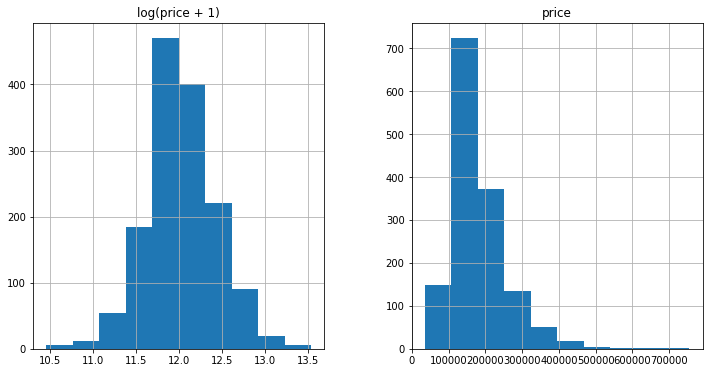

In [19]:
matplotlib.rcParams['figure.figsize'] = (12.0, 6.0)
prices = pd.DataFrame({"price":train["SalePrice"], "log(price + 1)":np.log1p(train["SalePrice"])})
prices.hist()
prices.head()

In [20]:
prices.shape

(1460, 2)

In [21]:
#log transform the target:
train["SalePrice"] = np.log1p(train["SalePrice"])

In [22]:
numeric_feats = all_X.dtypes[all_X.dtypes != "object"].index

In [23]:
type(numeric_feats)

pandas.core.indexes.base.Index

In [24]:
skewed_feats = train[numeric_feats].apply(lambda x: skew(x.dropna())) #compute skewness
skewed_feats

MSSubClass        1.406210
LotFrontage       2.160866
LotArea          12.195142
OverallQual       0.216721
OverallCond       0.692355
YearBuilt        -0.612831
YearRemodAdd     -0.503044
MasVnrArea        2.666326
BsmtFinSF1        1.683771
BsmtFinSF2        4.250888
BsmtUnfSF         0.919323
TotalBsmtSF       1.522688
1stFlrSF          1.375342
2ndFlrSF          0.812194
LowQualFinSF      9.002080
GrLivArea         1.365156
BsmtFullBath      0.595454
BsmtHalfBath      4.099186
FullBath          0.036524
HalfBath          0.675203
BedroomAbvGr      0.211572
KitchenAbvGr      4.483784
TotRmsAbvGrd      0.675646
Fireplaces        0.648898
GarageYrBlt      -0.648708
GarageCars       -0.342197
GarageArea        0.179796
WoodDeckSF        1.539792
OpenPorchSF       2.361912
EnclosedPorch     3.086696
3SsnPorch        10.293752
ScreenPorch       4.117977
PoolArea         14.813135
MiscVal          24.451640
MoSold            0.211835
YrSold            0.096170
dtype: float64

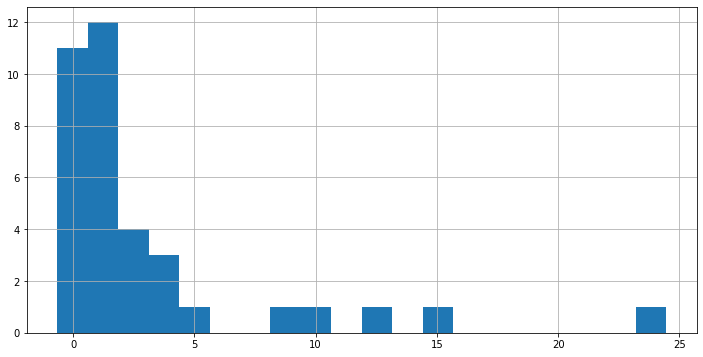

In [25]:
skewed_feats.hist(bins=20)

In [26]:
skewed_feats[skewed_feats > 0.75]

MSSubClass        1.406210
LotFrontage       2.160866
LotArea          12.195142
MasVnrArea        2.666326
BsmtFinSF1        1.683771
BsmtFinSF2        4.250888
BsmtUnfSF         0.919323
TotalBsmtSF       1.522688
1stFlrSF          1.375342
2ndFlrSF          0.812194
LowQualFinSF      9.002080
GrLivArea         1.365156
BsmtHalfBath      4.099186
KitchenAbvGr      4.483784
WoodDeckSF        1.539792
OpenPorchSF       2.361912
EnclosedPorch     3.086696
3SsnPorch        10.293752
ScreenPorch       4.117977
PoolArea         14.813135
MiscVal          24.451640
dtype: float64

In [27]:
skewed_feats = skewed_feats[skewed_feats > 0.75]
skewed_feats = skewed_feats.index
skewed_feats

Index(['MSSubClass', 'LotFrontage', 'LotArea', 'MasVnrArea', 'BsmtFinSF1',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtHalfBath', 'KitchenAbvGr',
       'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch',
       'ScreenPorch', 'PoolArea', 'MiscVal'],
      dtype='object')

In [28]:
all_X[skewed_feats] 

,MSSubClass,LotFrontage,LotArea,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,...,GrLivArea,BsmtHalfBath,KitchenAbvGr,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal
0,60,65.0,8450,196.0,706.0,0.0,150.0,856.0,856,854,...,1710,0.0,1,0,61,0,0,0,0,0
1,20,80.0,9600,0.0,978.0,0.0,284.0,1262.0,1262,0,...,1262,1.0,1,298,0,0,0,0,0,0
2,60,68.0,11250,162.0,486.0,0.0,434.0,920.0,920,866,...,1786,0.0,1,0,42,0,0,0,0,0
3,70,60.0,9550,0.0,216.0,0.0,540.0,756.0,961,756,...,1717,0.0,1,0,35,272,0,0,0,0
4,60,84.0,14260,350.0,655.0,0.0,490.0,1145.0,1145,1053,...,2198,0.0,1,192,84,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,160,21.0,1936,0.0,0.0,0.0,546.0,546.0,546,546,...,1092,0.0,1,0,0,0,0,0,0,0
1455,160,21.0,1894,0.0,252.0,0.0,294.0,546.0,546,546,...,1092,0.0,1,0,24,0,0,0,0,0
1456,20,160.0,20000,0.0,1224.0,0.0,0.0,1224.0,1224,0,...,1224,0.0,1,474,0,0,0,0,0,0
1457,85,62.0,10441,0.0,337.0,0.0,575.0,912.0,970,0,...,970,1.0,1,80,32,0,0,0,0,700


In [29]:
numeric_data = all_X[skewed_feats]

In [30]:
np.log1p(numeric_data).isnull().sum()

/Users/JK/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in log1p
  """Entry point for launching an IPython kernel.


MSSubClass         0
LotFrontage      486
LotArea            0
MasVnrArea        23
BsmtFinSF1         1
BsmtFinSF2         1
BsmtUnfSF          1
TotalBsmtSF        1
1stFlrSF           0
2ndFlrSF           0
LowQualFinSF       0
GrLivArea          0
BsmtHalfBath       2
KitchenAbvGr       0
WoodDeckSF         0
OpenPorchSF        0
EnclosedPorch      0
3SsnPorch          0
ScreenPorch        0
PoolArea           0
MiscVal            0
dtype: int64

In [31]:
np.log1p(numeric_data)

/Users/JK/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in log1p
  """Entry point for launching an IPython kernel.


,MSSubClass,LotFrontage,LotArea,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,...,GrLivArea,BsmtHalfBath,KitchenAbvGr,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal
0,4.110874,4.189655,9.042040,5.283204,6.561031,0.0,5.017280,6.753438,6.753438,6.751101,...,7.444833,0.000000,0.693147,0.000000,4.127134,0.000000,0.0,0.0,0.0,0.000000
1,3.044522,4.394449,9.169623,0.000000,6.886532,0.0,5.652489,7.141245,7.141245,0.000000,...,7.141245,0.693147,0.693147,5.700444,0.000000,0.000000,0.0,0.0,0.0,0.000000
2,4.110874,4.234107,9.328212,5.093750,6.188264,0.0,6.075346,6.825460,6.825460,6.765039,...,7.488294,0.000000,0.693147,0.000000,3.761200,0.000000,0.0,0.0,0.0,0.000000
3,4.262680,4.110874,9.164401,0.000000,5.379897,0.0,6.293419,6.629363,6.869014,6.629363,...,7.448916,0.000000,0.693147,0.000000,3.583519,5.609472,0.0,0.0,0.0,0.000000
4,4.110874,4.442651,9.565284,5.860786,6.486161,0.0,6.196444,7.044033,7.044033,6.960348,...,7.695758,0.000000,0.693147,5.262690,4.442651,0.000000,0.0,0.0,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,5.081404,3.091042,7.568896,0.000000,0.000000,0.0,6.304449,6.304449,6.304449,6.304449,...,6.996681,0.000000,0.693147,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000
1455,5.081404,3.091042,7.546974,0.000000,5.533389,0.0,5.686975,6.304449,6.304449,6.304449,...,6.996681,0.000000,0.693147,0.000000,3.218876,0.000000,0.0,0.0,0.0,0.000000
1456,3.044522,5.081404,9.903538,0.000000,7.110696,0.0,0.000000,7.110696,7.110696,0.000000,...,7.110696,0.000000,0.693147,6.163315,0.000000,0.000000,0.0,0.0,0.0,0.000000
1457,4.454347,4.143135,9.253591,0.000000,5.823046,0.0,6.356108,6.816736,6.878326,0.000000,...,6.878326,0.693147,0.693147,4.394449,3.496508,0.000000,0.0,0.0,0.0,6.552508


In [32]:
all_X[skewed_feats] = np.log1p(numeric_data)

/Users/JK/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in log1p
  """Entry point for launching an IPython kernel.


In [33]:
all_X[skewed_feats].head()

,MSSubClass,LotFrontage,LotArea,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,...,GrLivArea,BsmtHalfBath,KitchenAbvGr,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal
0,4.110874,4.189655,9.042040,5.283204,6.561031,0.0,5.017280,6.753438,6.753438,6.751101,...,7.444833,0.000000,0.693147,0.000000,4.127134,0.000000,0.0,0.0,0.0,0.0
1,3.044522,4.394449,9.169623,0.000000,6.886532,0.0,5.652489,7.141245,7.141245,0.000000,...,7.141245,0.693147,0.693147,5.700444,0.000000,0.000000,0.0,0.0,0.0,0.0
2,4.110874,4.234107,9.328212,5.093750,6.188264,0.0,6.075346,6.825460,6.825460,6.765039,...,7.488294,0.000000,0.693147,0.000000,3.761200,0.000000,0.0,0.0,0.0,0.0
3,4.262680,4.110874,9.164401,0.000000,5.379897,0.0,6.293419,6.629363,6.869014,6.629363,...,7.448916,0.000000,0.693147,0.000000,3.583519,5.609472,0.0,0.0,0.0,0.0
4,4.110874,4.442651,9.565284,5.860786,6.486161,0.0,6.196444,7.044033,7.044033,6.960348,...,7.695758,0.000000,0.693147,5.262690,4.442651,0.000000,0.0,0.0,0.0,0.0


In [34]:
all_X.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,4.110874,RL,4.189655,9.042040,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0.0,0.0,NaN,NaN,NaN,0.0,2,2008,WD,Normal
1,3.044522,RL,4.394449,9.169623,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0.0,0.0,NaN,NaN,NaN,0.0,5,2007,WD,Normal
2,4.110874,RL,4.234107,9.328212,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0.0,0.0,NaN,NaN,NaN,0.0,9,2008,WD,Normal
3,4.262680,RL,4.110874,9.164401,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0.0,0.0,NaN,NaN,NaN,0.0,2,2006,WD,Abnorml
4,4.110874,RL,4.442651,9.565284,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0.0,0.0,NaN,NaN,NaN,0.0,12,2008,WD,Normal


In [35]:
all_X.shape

(2919, 79)

In [36]:
#Create Dummy variables for the categorical features

all_X = pd.get_dummies(all_X)

all_X.shape

(2919, 288)

In [37]:
all_X.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,4.110874,4.189655,9.042040,7,5,2003,2003,5.283204,6.561031,0.0,...,0,0,0,1,0,0,0,0,1,0
1,3.044522,4.394449,9.169623,6,8,1976,1976,0.000000,6.886532,0.0,...,0,0,0,1,0,0,0,0,1,0
2,4.110874,4.234107,9.328212,7,5,2001,2002,5.093750,6.188264,0.0,...,0,0,0,1,0,0,0,0,1,0
3,4.262680,4.110874,9.164401,7,5,1915,1970,0.000000,5.379897,0.0,...,0,0,0,1,1,0,0,0,0,0
4,4.110874,4.442651,9.565284,8,5,2000,2000,5.860786,6.486161,0.0,...,0,0,0,1,0,0,0,0,1,0


In [38]:
#filling NA's with the mean of the column:
all_X = all_X.fillna(all_X.mean())

In [39]:
#creating matrices for sklearn:
X_train = all_X[:train.shape[0]]
X_test = all_X[train.shape[0]:]
y_train = train.SalePrice

In [40]:
X_train.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,4.110874,4.189655,9.042040,7,5,2003,2003,5.283204,6.561031,0.0,...,0,0,0,1,0,0,0,0,1,0
1,3.044522,4.394449,9.169623,6,8,1976,1976,0.000000,6.886532,0.0,...,0,0,0,1,0,0,0,0,1,0
2,4.110874,4.234107,9.328212,7,5,2001,2002,5.093750,6.188264,0.0,...,0,0,0,1,0,0,0,0,1,0
3,4.262680,4.110874,9.164401,7,5,1915,1970,0.000000,5.379897,0.0,...,0,0,0,1,1,0,0,0,0,0
4,4.110874,4.442651,9.565284,8,5,2000,2000,5.860786,6.486161,0.0,...,0,0,0,1,0,0,0,0,1,0


In [41]:
y_train.head()

0    12.247699
1    12.109016
2    12.317171
3    11.849405
4    12.429220
Name: SalePrice, dtype: float64

In [42]:
X_train.shape

(1460, 288)

In [43]:
X_test.shape

(1459, 288)

In [44]:
y_train.shape

(1460,)

# Predictive Modeling



Now we are going to use regularized linear regression models from the scikit learn module. I'm going to try both l_1(Lasso) and l_2(Ridge) regularization. I'll also define a function that returns the cross-validation rmse error so we can evaluate our models and pick the best tuning hyperparameters

## Ridge

In [50]:
#Validation function with random shuffle
n_folds = 5
def rmsle_cv(model):
    kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(X_train)
    rmse= np.sqrt(-cross_val_score(model, X_train, y_train, scoring="neg_mean_squared_error", cv = kf))
    return(rmse)

In [51]:
model_ridge = Ridge()

In [52]:
model_ridge.fit(X_train,y_train)

Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001)

The main tuning parameter for the Ridge model is alpha - a regularization parameter that measures how flexible our model is. The higher the regularization the less prone our model will be to overfit. However it will also lose flexibility and might not capture all of the signal in the data.

In [53]:
alphas = [0.05, 0.1, 0.3, 1, 3, 5, 10, 15, 30, 50, 75]
cv_ridge = [rmsle_cv(Ridge(alpha = alpha)).mean()
            for alpha in alphas]
cv_ridge = pd.Series(cv_ridge, index = alphas)            

In [54]:
cv_ridge

0.05     0.138936
0.10     0.137775
0.30     0.135014
1.00     0.131362
3.00     0.128649
5.00     0.127822
10.00    0.127337
15.00    0.127529
30.00    0.128959
50.00    0.130994
75.00    0.133164
dtype: float64

In [57]:
cv_ridge.min()

0.12733734668670774

In [58]:
cv_ridge.idxmin()

10.0

Text(12, 0.13, 'best alpha')

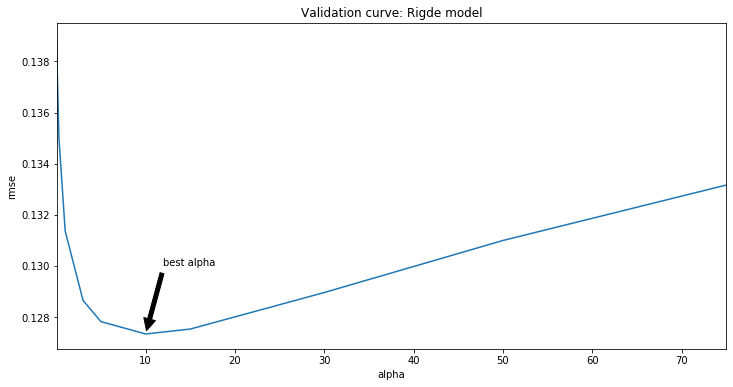

In [59]:
matplotlib.rcParams['figure.figsize'] = (12.0, 6.0)
cv_ridge = pd.Series(cv_ridge, index = alphas)
ax = cv_ridge.plot(title = "Validation curve: Rigde model")
ax.set(xlabel='alpha', ylabel='rmse',
       title="Validation curve: Rigde model");
# style = dict(size=10, color='gray')
# ax.text(10, cv_ridge[10]-0.0005, "best alpha",ha='center', **style)
ax.annotate('best alpha', xy=(cv_ridge.idxmin(), cv_ridge.min()), xytext=(12, 0.13),
            arrowprops=dict(facecolor='black', shrink=0.05))

Note the U-ish shaped curve above. When alpha is too large the regularization is too strong and the model cannot capture all the complexities in the data. If however we let the model be too flexible (alpha small) the model begins to overfit. A value of alpha = 10 is about right based on the plot above.

So for the Ridge regression we get a rmsle of about 0.127



## Lasso

#### Let' try out the Lasso model. I will do a slightly different approach here and use the built in Lasso CV to figure out the best alpha. 

In [61]:
model_lasso = LassoCV(alphas = [1, 0.1, 0.001, 0.0005],cv= 5).fit(X_train, y_train)

In [62]:
# optimal alpha wit cross validation is 0.0005
model_lasso.alpha_

0.0005

In [63]:
model_lasso.alphas_

array([1.e+00, 1.e-01, 1.e-03, 5.e-04])

In [64]:
rmsle_cv(model_lasso)

array([0.10330973, 0.13147319, 0.12552436, 0.10530453, 0.14722499])

In [65]:
rmsle_cv(model_lasso).mean()

0.12256735885048124

#### Let's add a RobustScaler with Pipeline, to scale the variables before training so we could better compare coefficients of the regression

In [67]:
lasso = make_pipeline(RobustScaler(), Lasso(alpha =0.0005))

In [68]:
rmsle_cv(lasso)

array([0.10321219, 0.13149904, 0.12558838, 0.10595377, 0.14660296])

In [69]:
rmsle_cv(lasso).mean()

0.1225712699993513

Nice! The lasso performs even better so we'll just use this one to predict on the test set. Another neat thing about the Lasso is that it does feature selection for you - setting coefficients of features it deems unimportant to zero. Let's take a look at the coefficients:

In [70]:
lasso.fit(X_train,y_train)

Pipeline(memory=None,
         steps=[('robustscaler',
                 RobustScaler(copy=True, quantile_range=(25.0, 75.0),
                              with_centering=True, with_scaling=True)),
                ('lasso',
                 Lasso(alpha=0.0005, copy_X=True, fit_intercept=True,
                       max_iter=1000, normalize=False, positive=False,
                       precompute=False, random_state=None, selection='cyclic',
                       tol=0.0001, warm_start=False))],
         verbose=False)

In [71]:
# store lasso coefficients
coef = pd.Series(lasso['lasso'].coef_, index = X_train.columns)

In [72]:
print("Lasso picked " + str(sum(coef != 0)) + " variables and eliminated the other " +  str(sum(coef == 0)) + " variables")

Lasso picked 112 variables and eliminated the other 176 variables


Good job Lasso.  One thing to note here however is that the features selected are not necessarily the "correct" ones - especially since there are a lot of collinear features in this dataset. One idea to try here is run Lasso a few times on boostrapped samples and see how stable the feature selection is.

We can also take a look directly at what the most important coefficients are:

In [73]:
imp_coef = pd.concat([coef.sort_values().head(10),
                     coef.sort_values().tail(10)])

Text(0.5, 1.0, 'Coefficients in the Lasso Model')

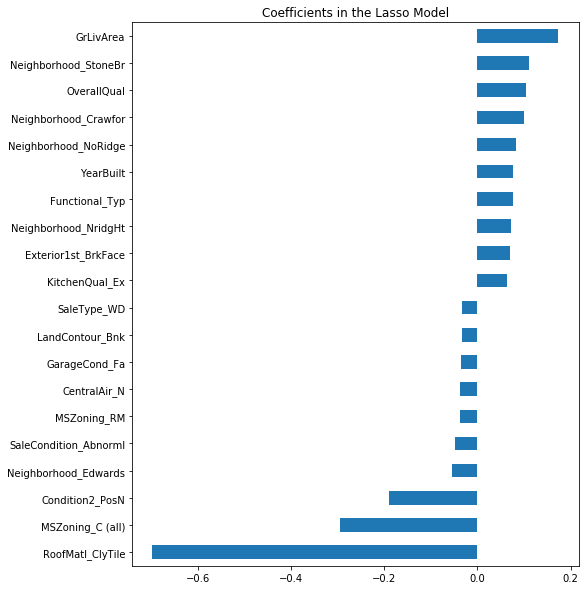

In [74]:
matplotlib.rcParams['figure.figsize'] = (8.0, 10.0)
imp_coef.plot(kind = "barh")
plt.title("Coefficients in the Lasso Model")

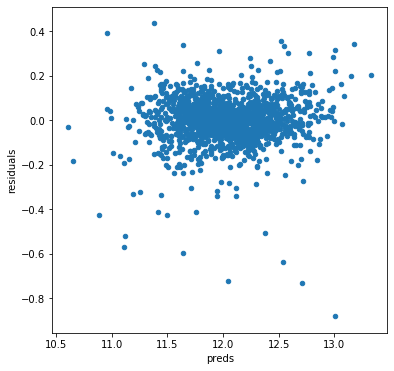

In [76]:
#let's look at the residuals as well:
matplotlib.rcParams['figure.figsize'] = (6.0, 6.0)

preds = pd.DataFrame({"preds":lasso.predict(X_train), "true":y_train})
preds["residuals"] = preds["true"] - preds["preds"]
preds.plot(x = "preds", y = "residuals",kind = "scatter")

## Lasso,  Ridge, RandomForest and boosting models (with pipeline)

Now let's try some other models as well
- random forest
- gradient boost
- xgboost
- lightgbm

In [77]:
models = {"lasso": make_pipeline(RobustScaler(), Lasso(alpha =0.0005)),
          "Enet" : make_pipeline(RobustScaler(), ElasticNet(alpha=0.0005, l1_ratio=.9)),
          "ridge": make_pipeline(RobustScaler(), Ridge(alpha =10))}
    
for name, model in models.items():
    score = rmsle_cv(model)
    print(name, model)

lasso Pipeline(memory=None,
         steps=[('robustscaler',
                 RobustScaler(copy=True, quantile_range=(25.0, 75.0),
                              with_centering=True, with_scaling=True)),
                ('lasso',
                 Lasso(alpha=0.0005, copy_X=True, fit_intercept=True,
                       max_iter=1000, normalize=False, positive=False,
                       precompute=False, random_state=None, selection='cyclic',
                       tol=0.0001, warm_start=False))],
         verbose=False)
Enet Pipeline(memory=None,
         steps=[('robustscaler',
                 RobustScaler(copy=True, quantile_range=(25.0, 75.0),
                              with_centering=True, with_scaling=True)),
                ('elasticnet',
                 ElasticNet(alpha=0.0005, copy_X=True, fit_intercept=True,
                            l1_ratio=0.9, max_iter=1000, normalize=False,
                            positive=False, precompute=False, random_state=None,
       

In [78]:
models = {"lasso": make_pipeline(RobustScaler(), Lasso(alpha =0.0005)),
          "Enet" : make_pipeline(RobustScaler(), ElasticNet(alpha=0.0005, l1_ratio=.9)),
          "ridge": make_pipeline(RobustScaler(), Ridge(alpha =10))}
    
for name, model in models.items():
    score = rmsle_cv(model)
    print("\n Model {}'s validation score: {:.4f} and standard deviation: ({:.4f})\n".format(name,score.mean(), score.std()))


 Model lasso's validation score: 0.1226 and standard deviation: (0.0162)


 Model Enet's validation score: 0.1226 and standard deviation: (0.0163)


 Model ridge's validation score: 0.1264 and standard deviation: (0.0156)



In [329]:
models = {"lasso": make_pipeline(RobustScaler(), Lasso(alpha =0.0005)),
          "Enet" : make_pipeline(RobustScaler(), ElasticNet(alpha=0.0005, l1_ratio=.9)),
          "ridge": make_pipeline(RobustScaler(), Ridge(alpha =10)),
#           "RandomForest": RandomForestRegressor(),
#           "GBoost": GradientBoostingRegressor(),
#           "model_xgb": xgb.XGBRegressor(),
#           "model_lgb": lgb.LGBMRegressor()}
         
    
for name, model in models.items():
    score = rmsle_cv(model)
    print(name, score)

SyntaxError: invalid syntax (<ipython-input-329-bcd5a519ca83>, line 3)

In [128]:
# lasso, ENet, KRR, GBoost, model_xgb, model_lgb
lasso = make_pipeline(RobustScaler(), Lasso(alpha =0.0005, random_state=1))
ENet = make_pipeline(RobustScaler(), ElasticNet(alpha=0.0005, l1_ratio=.9, random_state=3))
KRR = KernelRidge(alpha=0.6, kernel='polynomial', degree=2, coef0=2.5)
GBoost = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05,
                                   max_depth=4, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=10, 
                                   loss='huber', random_state =5)
model_xgb = xgb.XGBRegressor(colsample_bytree=0.4603, gamma=0.0468, 
                             learning_rate=0.05, max_depth=3, 
                             min_child_weight=1.7817, n_estimators=2200,
                             reg_alpha=0.4640, reg_lambda=0.8571,
                             subsample=0.5213, silent=1,
                             random_state =7, nthread = -1)
model_lgb = lgb.LGBMRegressor(objective='regression',num_leaves=5,
                              learning_rate=0.05, n_estimators=720,
                              max_bin = 55, bagging_fraction = 0.8,
                              bagging_freq = 5, feature_fraction = 0.2319,
                              feature_fraction_seed=9, bagging_seed=9,
                              min_data_in_leaf =6, min_sum_hessian_in_leaf = 11)

## Random Forest

In [ ]:
# Random Forest hyperparameter tuning

In [80]:
RandomForestRegressor()

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators='warn',
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

In [94]:
%%time
number_of_tree = [10, 20, 50, 75, 100, 150, 200]
cv_RF = [rmsle_cv(RandomForestRegressor(n_estimators = n, random_state=42)).mean()
            for n in number_of_tree]
cv_RF = pd.Series(cv_RF, index = number_of_tree)  

CPU times: user 1min 18s, sys: 720 ms, total: 1min 19s
Wall time: 1min 23s


In [97]:
%%time
rmsle_cv(RandomForestRegressor(n_estimators=500)).mean()

CPU times: user 1min 2s, sys: 662 ms, total: 1min 3s
Wall time: 1min 8s


0.142528569123056

In [98]:
%%time
rmsle_cv(RandomForestRegressor(n_estimators=1000)).mean()

CPU times: user 2min 4s, sys: 1.01 s, total: 2min 5s
Wall time: 2min 10s


0.1425921251376219

In [95]:
cv_RF

10     0.150413
20     0.146741
50     0.145305
75     0.143870
100    0.143518
150    0.142723
200    0.142850
dtype: float64

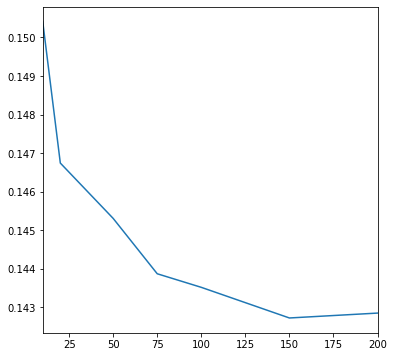

In [96]:
cv_RF.plot()

In [86]:
cv_RF

10     0.150317
20     0.148018
50     0.143254
75     0.143407
100    0.143337
150    0.142782
200    0.143258
dtype: float64

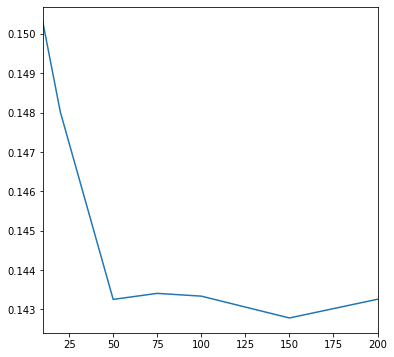

In [90]:
cv_RF.plot()

In [82]:
cv_RF

10     0.153839
20     0.147687
50     0.145664
75     0.144112
100    0.144661
150    0.142931
200    0.142192
dtype: float64

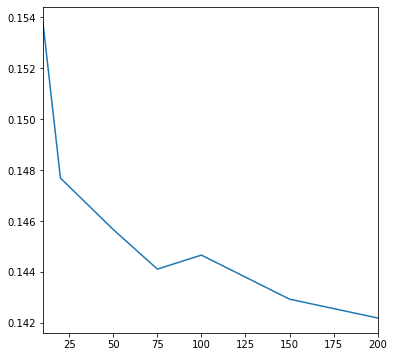

In [84]:
cv_RF.plot()

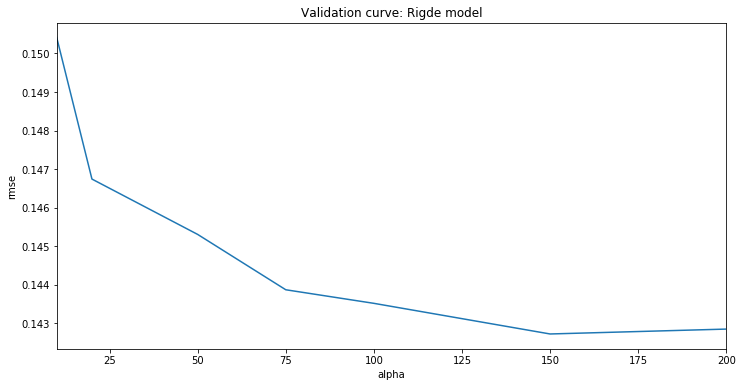

In [99]:

matplotlib.rcParams['figure.figsize'] = (12.0, 6.0)
ax = cv_RF.plot(title = "Validation curve: Rigde model")
ax.set(xlabel='alpha', ylabel='rmse',
       title="Validation curve: Rigde model");

number_of_tree: 150

## SKLearn Gradient Boost Regressor

In [ ]:
# Gradient Boost hyperparameter tuning

MSE: 0.0113
Loss: 0.0113


Text(0, 0.5, 'Deviance')

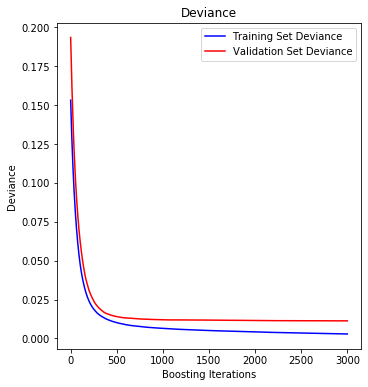

In [118]:
X_train1, X_test1, y_train1 , y_test1 = train_test_split(X_train, y_train, test_size=0.1, random_state=42 )

# #############################################################################

# Fit regression model
params = {'n_estimators': 3000, 'max_depth': 3, 'min_samples_split': 2,
          'learning_rate': 0.01, 'loss': 'ls'}
clf = GradientBoostingRegressor(**params)

clf.fit(X_train1, y_train1)
mse = mean_squared_error(y_test1, clf.predict(X_test1))
print("MSE: %.4f" % mse)
mse2 = clf.loss_(y_test1, clf.predict(X_test1))
print("Loss: %.4f" % mse2)

# #############################################################################
# Plot training deviance

# compute test set deviance
test_score = np.zeros((params['n_estimators'],), dtype=np.float64)

for i, y_pred in enumerate(clf.staged_predict(X_test1)):
    test_score[i] = clf.loss_(y_test1, y_pred)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title('Deviance')
plt.plot(np.arange(params['n_estimators']) + 1, clf.train_score_, 'b-',
         label='Training Set Deviance')
plt.plot(np.arange(params['n_estimators']) + 1, test_score, 'r-',
         label='Validation Set Deviance')
plt.legend(loc='upper right')
plt.xlabel('Boosting Iterations')
plt.ylabel('Deviance')

n_estimators : 500

## XGBM

In [ ]:
# xgb Boost hyperparameter tuning

In [122]:
model_xgb

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.4603, gamma=0.0468,
             importance_type='gain', learning_rate=0.05, max_delta_step=0,
             max_depth=3, min_child_weight=1.7817, missing=None,
             n_estimators=2200, n_jobs=1, nthread=-1, objective='reg:linear',
             random_state=7, reg_alpha=0.464, reg_lambda=0.8571,
             scale_pos_weight=1, seed=None, silent=1, subsample=0.5213,
             verbosity=1)

In [124]:
xgb.XGBRegressor()

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

In [148]:
%%time
number_of_tree = [10,  50, 100, 150, 200]
cv_xgb = [rmsle_cv(xgb.XGBRegressor(n_estimators = n, random_state=42)).mean()
            for n in number_of_tree]
cv_xgb = pd.Series(cv_xgb, index = number_of_tree)  

/Users/JK/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/JK/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[02:06:20] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[02:06:20] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/JK/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/JK/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[02:06:20] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[02:06:20] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/JK/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/JK/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[02:06:20] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[02:06:21] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/JK/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[02:06:21] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/JK/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[02:06:22] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/JK/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[02:06:23] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/JK/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[02:06:24] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/JK/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[02:06:25] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/JK/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[02:06:27] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/JK/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[02:06:29] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/JK/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[02:06:32] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/JK/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[02:06:34] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/JK/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[02:06:37] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/JK/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[02:06:40] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/JK/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[02:06:43] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/JK/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[02:06:45] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/JK/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[02:06:48] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/JK/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[02:06:51] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/JK/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[02:06:54] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/JK/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[02:06:58] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/JK/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[02:07:02] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/JK/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[02:07:06] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
CPU times: user 50.4 s, sys: 368 ms, total: 50.7 s
Wall time: 50.3 s


In [153]:
cv_xgb

10     4.036445
50     0.156657
100    0.130829
150    0.127591
200    0.126079
dtype: float64

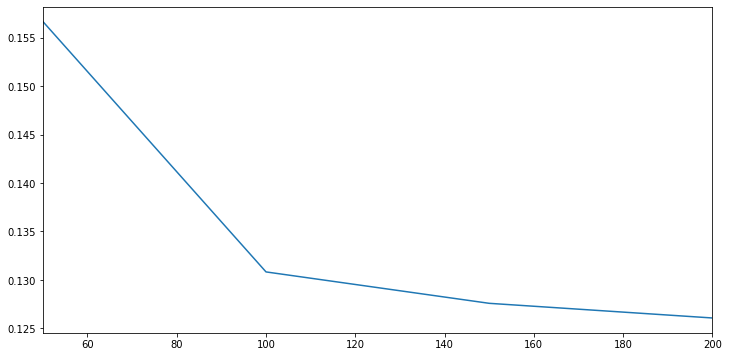

In [152]:
cv_xgb[1:].plot()

In [154]:
%%time
score = rmsle_cv(model_xgb)
print("Xgboost score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

/Users/JK/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/JK/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/JK/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/JK/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/JK/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None a

Xgboost score: 0.1227 (0.0103)

CPU times: user 1min 54s, sys: 509 ms, total: 1min 54s
Wall time: 2min 1s


In [192]:
%%time
estimator = xgb.XGBRegressor(random_state=42)

param_grid = {
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [25, 50, 100, 150, 200, 500]
}

xbm = GridSearchCV(estimator, param_grid, cv=3)
xbm.fit(X_train, y_train)

print('Best parameters found by grid search are:', xbm.best_params_)

/Users/JK/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[03:06:19] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/JK/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[03:06:20] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/JK/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[03:06:20] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/JK/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[03:06:20] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/JK/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[03:06:21] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/JK/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[03:06:21] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/JK/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[03:06:22] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/JK/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[03:06:23] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/JK/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[03:06:24] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/JK/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[03:06:26] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/JK/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[03:06:28] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/JK/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[03:06:30] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/JK/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[03:06:31] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/JK/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[03:06:34] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/JK/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[03:06:36] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/JK/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[03:06:39] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/JK/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[03:06:47] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/JK/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[03:06:54] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/JK/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[03:07:04] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/JK/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[03:07:05] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/JK/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[03:07:05] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/JK/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[03:07:05] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/JK/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[03:07:06] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/JK/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[03:07:07] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/JK/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[03:07:08] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/JK/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[03:07:10] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/JK/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[03:07:12] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/JK/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[03:07:14] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/JK/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[03:07:17] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/JK/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[03:07:20] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/JK/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[03:07:23] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/JK/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[03:07:26] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/JK/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[03:07:29] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/JK/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[03:07:35] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/JK/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[03:07:44] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/JK/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[03:07:52] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/JK/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[03:07:59] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/JK/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[03:07:59] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/JK/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[03:08:00] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/JK/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[03:08:00] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/JK/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[03:08:01] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/JK/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[03:08:02] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/JK/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[03:08:03] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/JK/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[03:08:04] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/JK/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[03:08:05] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/JK/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[03:08:07] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/JK/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[03:08:09] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/JK/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[03:08:11] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/JK/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[03:08:14] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/JK/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[03:08:17] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/JK/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[03:08:20] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/JK/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[03:08:23] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/JK/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[03:08:30] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/JK/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[03:08:38] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/JK/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/JK/anaconda3/lib/python3.7/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[03:08:45] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Best parameters found by grid search are: {'learning_rate': 0.1, 'n_estimators': 500}
CPU times: user 2min 34s, sys: 1.01 s, total: 2min 35s
Wall time: 2min 37s


In [193]:
temp = rmsle_cv(xgb.XGBRegressor(n_estimators = 500, random_state=42))

[03:12:58] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/JK/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[03:13:08] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/JK/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[03:13:19] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/JK/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[03:13:28] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/JK/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[03:13:37] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [194]:
temp

array([0.10904059, 0.13992918, 0.1260826 , 0.11877016, 0.12608227])

In [195]:
temp.mean()

0.12398096295965137

## LightGBM

In [ ]:
# hyperparameter tuning for LGBM

In [125]:
lgb.LGBMRegressor()

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=-1,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
              random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [159]:
%%time
number_of_tree = [10,  50, 100, 150, 200, 300,500]
cv_lgb = [rmsle_cv(lgb.LGBMRegressor(n_estimators = n,learning_rate=0.05, random_state=42)).mean()
            for n in number_of_tree]
cv_lgb = pd.Series(cv_lgb, index = number_of_tree)  

CPU times: user 26.4 s, sys: 431 ms, total: 26.8 s
Wall time: 33.2 s


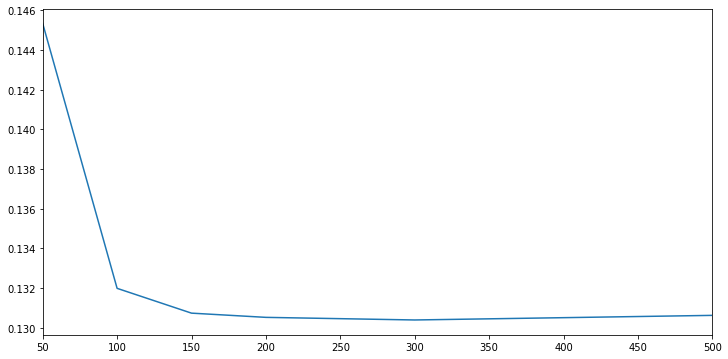

In [161]:
cv_lgb[1:].plot()

#### GridSearchCV

In [167]:
%%time
estimator = lgb.LGBMRegressor(num_leaves=31)

param_grid = {
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [25, 50, 100, 150, 200, 500]
}

gbm = GridSearchCV(estimator, param_grid, cv=3)
gbm.fit(X_train, y_train)

print('Best parameters found by grid search are:', gbm.best_params_)

Best parameters found by grid search are: {'learning_rate': 0.05, 'n_estimators': 200}
CPU times: user 30.4 s, sys: 428 ms, total: 30.8 s
Wall time: 32.5 s


In [174]:
%%time
tempa = rmsle_cv(gbm)

array([0.12333927, 0.14383463, 0.13534785, 0.11816547, 0.13339808])

In [205]:
%%time
tempa = rmsle_cv(gbm)

CPU times: user 2min 23s, sys: 2.27 s, total: 2min 25s
Wall time: 2min 46s


In [206]:
tempa

array([0.12333927, 0.14383463, 0.13534785, 0.11816547, 0.13339808])

In [199]:
tempb = rmsle_cv(lgb.LGBMRegressor(n_estimators = 200,learning_rate=0.05, random_state=42))

In [200]:
tempb

array([0.12187792, 0.14383463, 0.13534785, 0.11816547, 0.13339808])

In [201]:
tempb.mean()

0.13052478879838142

#### RandomSearchCV

In [208]:
gbm.estimator

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=-1,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
              random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [218]:
#grid of parameters
gridParams = {
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [25, 50, 100, 150, 200, 500],
    'boosting_type' : ['gbdt'],
    'max_depth' : [5,6,7,8],
    'random_state' : [42], 
}

In [219]:
%%time
estimator = lgb.LGBMRegressor(num_leaves=31)
randgrid = RandomizedSearchCV(estimator,gridParams,verbose=1,cv=10,n_jobs = -1,n_iter=10)
randgrid.fit(X_train,y_train)

Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   15.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   34.3s finished


CPU times: user 2.26 s, sys: 124 ms, total: 2.38 s
Wall time: 35.3 s


RandomizedSearchCV(cv=10, error_score='raise-deprecating',
                   estimator=LGBMRegressor(boosting_type='gbdt',
                                           class_weight=None,
                                           colsample_bytree=1.0,
                                           importance_type='split',
                                           learning_rate=0.1, max_depth=-1,
                                           min_child_samples=20,
                                           min_child_weight=0.001,
                                           min_split_gain=0.0, n_estimators=100,
                                           n_jobs=-1, num_leaves=31,
                                           objective=None, random_state=None,
                                           reg_alpha=0.0, reg...
                                           silent=True, subsample=1.0,
                                           subsample_for_bin=200000,
                                        

In [220]:
randgrid.best_params_

{'random_state': 42,
 'n_estimators': 500,
 'max_depth': 8,
 'learning_rate': 0.1,
 'boosting_type': 'gbdt'}

In [221]:
tempb = rmsle_cv(lgb.LGBMRegressor(n_estimators = 500,learning_rate=0.1, max_depth=8, random_state=42))

In [223]:
tempb

array([0.1228968 , 0.1408065 , 0.14064589, 0.12446927, 0.13231924])

In [222]:
tempb.mean()

0.13222753936923692

### validation scores

In [182]:
score = rmsle_cv(lasso)
print("\nLasso score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))


score = rmsle_cv(ENet)
print("ElasticNet score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))


score = rmsle_cv(KRR)
print("Kernel Ridge score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))


score = rmsle_cv(GBoost)
print("Gradient Boosting score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))


score = rmsle_cv(model_xgb)
print("Xgboost score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))


score = rmsle_cv(model_lgb)
print("LGBM score: {:.4f} ({:.4f})\n" .format(score.mean(), score.std()))


Lasso score: 0.1226 (0.0162)

ElasticNet score: 0.1226 (0.0163)

Kernel Ridge score: 0.1684 (0.0193)

Gradient Boosting score: 0.1239 (0.0133)



/Users/JK/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/JK/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/JK/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/JK/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/JK/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None a

Xgboost score: 0.1227 (0.0103)

LGBM score: 0.1234 (0.0111)



We could see, the boosting models are performing around the the same level as our regularized regression models

# Plot residuals of prediction under different models

we need to fit models first

In [187]:
lasso.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('robustscaler',
                 RobustScaler(copy=True, quantile_range=(25.0, 75.0),
                              with_centering=True, with_scaling=True)),
                ('lasso',
                 Lasso(alpha=0.0005, copy_X=True, fit_intercept=True,
                       max_iter=1000, normalize=False, positive=False,
                       precompute=False, random_state=1, selection='cyclic',
                       tol=0.0001, warm_start=False))],
         verbose=False)

In [188]:
ENet.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('robustscaler',
                 RobustScaler(copy=True, quantile_range=(25.0, 75.0),
                              with_centering=True, with_scaling=True)),
                ('elasticnet',
                 ElasticNet(alpha=0.0005, copy_X=True, fit_intercept=True,
                            l1_ratio=0.9, max_iter=1000, normalize=False,
                            positive=False, precompute=False, random_state=3,
                            selection='cyclic', tol=0.0001,
                            warm_start=False))],
         verbose=False)

In [189]:
KRR.fit(X_train, y_train)

KernelRidge(alpha=0.6, coef0=2.5, degree=2, gamma=None, kernel='polynomial',
            kernel_params=None)

In [190]:
GBoost.fit(X_train, y_train)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                          learning_rate=0.05, loss='huber', max_depth=4,
                          max_features='sqrt', max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=15, min_samples_split=10,
                          min_weight_fraction_leaf=0.0, n_estimators=3000,
                          n_iter_no_change=None, presort='auto', random_state=5,
                          subsample=1.0, tol=0.0001, validation_fraction=0.1,
                          verbose=0, warm_start=False)

In [191]:
model_xgb.fit(X_train, y_train)

/Users/JK/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/JK/anaconda3/lib/python3.7/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.4603, gamma=0.0468,
             importance_type='gain', learning_rate=0.05, max_delta_step=0,
             max_depth=3, min_child_weight=1.7817, missing=None,
             n_estimators=2200, n_jobs=1, nthread=-1, objective='reg:linear',
             random_state=7, reg_alpha=0.464, reg_lambda=0.8571,
             scale_pos_weight=1, seed=None, silent=1, subsample=0.5213,
             verbosity=1)

In [192]:
model_lgb.fit(X_train, y_train)

LGBMRegressor(bagging_fraction=0.8, bagging_freq=5, bagging_seed=9,
              boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              feature_fraction=0.2319, feature_fraction_seed=9,
              importance_type='split', learning_rate=0.05, max_bin=55,
              max_depth=-1, min_child_samples=20, min_child_weight=0.001,
              min_data_in_leaf=6, min_split_gain=0.0,
              min_sum_hessian_in_leaf=11, n_estimators=720, n_jobs=-1,
              num_leaves=5, objective='regression', random_state=None,
              reg_alpha=0.0, reg_lambda=0.0, silent=True, subsample=1.0,
              subsample_for_bin=200000, subsample_freq=0)

Let's makes some plot

In [193]:
# define a function wrapper 
def plot_prdiction_residual(model):
    preds = pd.DataFrame({"preds":model.predict(X_train), "true":y_train})
    preds["residuals"] = preds["true"] - preds["preds"]
    preds.plot(x = "preds", y = "residuals",kind = "scatter", ylim=(-1, 0.5),title="Prediction vs Residual:")
    return

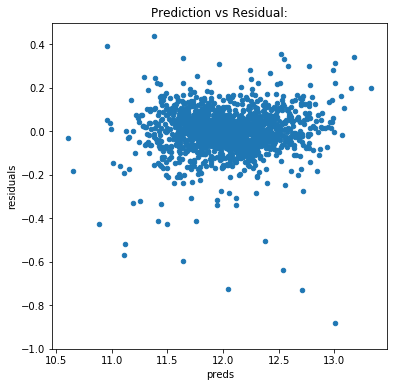

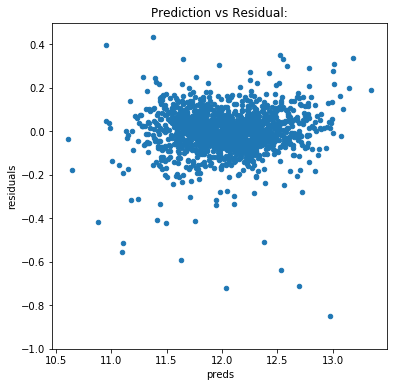

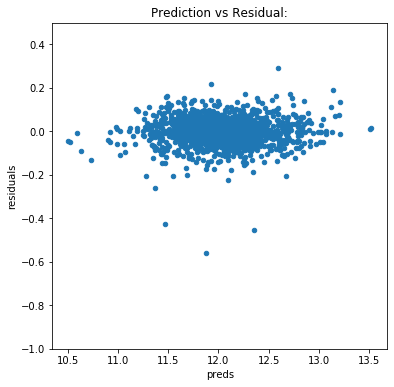

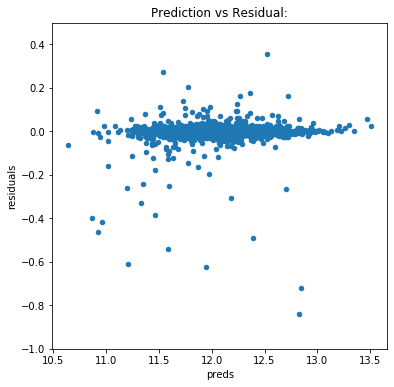

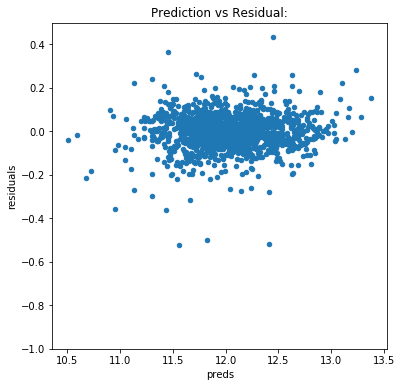

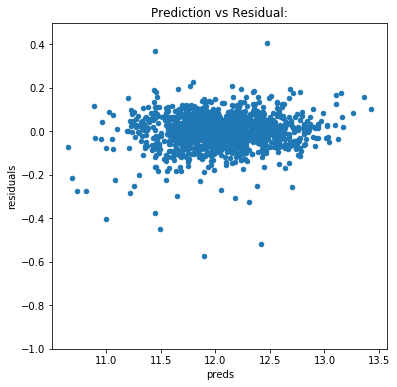

In [194]:
models = [lasso, ENet, KRR, GBoost, model_xgb, model_lgb]
for i in models:
    plot_prdiction_residual(i)

## Final Training and Prediction

In [195]:
def rmsle(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

In [196]:
lasso_train_pred = model_lasso.predict(X_train)
lasso_pred = np.expm1(model_lasso.predict(X_test))
print(rmsle(y_train, lasso_train_pred))

0.10502578262123977


In [197]:
lasso_train_pred = lasso.predict(X_train)
lasso_pred = np.expm1(lasso.predict(X_test))
print(rmsle(y_train, lasso_train_pred))

0.10497900918329381


In [198]:
ENet_train_pred = ENet.predict(X_train)
ENet_pred = np.expm1(ENet.predict(X_test))
print(rmsle(y_train, ENet_train_pred))

0.10403585205697068


In [199]:
KRR_train_pred = KRR.predict(X_train)
KRR_pred = np.expm1(KRR.predict(X_test))
print(rmsle(y_train, KRR_train_pred))

0.06182032482052553


In [200]:
GBoost_train_pred = GBoost.predict(X_train)
GBoost_pred = np.expm1(GBoost.predict(X_test))
print(rmsle(y_train, GBoost_train_pred))

0.058206184283354126


In [201]:
xgb_train_pred = model_xgb.predict(X_train)
xgb_pred = np.expm1(model_xgb.predict(X_test))
print(rmsle(y_train, xgb_train_pred))

0.07929070742478252


In [202]:
lgb_train_pred = model_lgb.predict(X_train)
lgb_pred = np.expm1(model_lgb.predict(X_test))
print(rmsle(y_train, lgb_train_pred))

0.07478606015269969


## Submission

In [ ]:
ensemble = GBoost_pred*0.70 + xgb_pred*0.15 + lgb_pred*0.15

In [210]:

sub = pd.DataFrame()
sub['Id'] = test['Id']
sub['SalePrice'] = ensemble
sub.to_csv('submission.csv',index=False)
